In [1]:
import pandas as pd
from sklearn.cluster import MiniBatchKMeans

import matplotlib.pyplot as plt
import seaborn as sns
import contextily as cx
import pickle

Read in training and test data, and inspect

In [2]:
rides_train = pd.read_csv("data/rides_train_clean.csv")
rides_test = pd.read_csv("data/rides_test_clean.csv")

In [3]:
rides_train.head()

,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,is_ebike,is_member,start_docked,end_docked,start_hour,end_hour,duration_mins
0,classic_bike,2021-03-20 09:46:54,2021-03-20 09:55:14,Convention Center / 7th & M St NW,31223.0,3rd & Elm St NW,31118.0,38.905737,-77.022270,38.917622,-77.015970,member,False,True,True,True,2021-03-20 09:00:00,2021-03-20 09:00:00,8.33
1,electric_bike,2021-03-12 16:37:17,2021-03-12 16:58:28,US Dept of State / Virginia Ave & 21st St NW,31220.0,Anacostia Roller Skating Pavillion,31720.0,38.894821,-77.046590,38.878772,-76.970906,member,True,True,True,True,2021-03-12 16:00:00,2021-03-12 16:00:00,21.18
2,classic_bike,2021-03-13 12:38:15,2021-03-13 13:04:01,Towers Crescent Dr & Tysons One Pl,32222.0,Dunn Loring Metro,32231.0,38.915246,-77.220157,38.882800,-77.228300,casual,False,False,True,True,2021-03-13 12:00:00,2021-03-13 13:00:00,25.77
3,classic_bike,2021-03-16 17:01:00,2021-03-16 17:06:00,14th & D St SE,31663.0,11th & C St SE,31659.0,38.884058,-76.986385,38.885908,-76.991476,member,False,True,True,True,2021-03-16 17:00:00,2021-03-16 17:00:00,5.00
4,classic_bike,2021-03-31 12:49:33,2021-03-31 12:52:17,14th & D St SE,31663.0,11th & C St SE,31659.0,38.884058,-76.986385,38.885908,-76.991476,member,False,True,True,True,2021-03-31 12:00:00,2021-03-31 12:00:00,2.73


In [4]:
rides_test.head()

,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,is_ebike,is_member,start_docked,end_docked,start_hour,end_hour,duration_mins
0,classic_bike,2023-06-28 16:10:03,2023-06-28 16:26:07,20th & O St NW / Dupont South,31234.0,14th & G St NW,31238.0,38.908905,-77.044780,38.898164,-77.031898,member,False,True,True,True,2023-06-28 16:00:00,2023-06-28 16:00:00,16.07
1,classic_bike,2023-06-04 15:01:05,2023-06-04 15:01:22,11th & V St NW,31332.0,11th & V St NW,31332.0,38.918199,-77.027171,38.918199,-77.027171,member,False,True,True,True,2023-06-04 15:00:00,2023-06-04 15:00:00,0.28
2,classic_bike,2023-06-24 16:21:20,2023-06-24 16:24:59,1st & D St SE,31643.0,1st & I St SE,31628.0,38.884916,-77.005965,38.878854,-77.005727,member,False,True,True,True,2023-06-24 16:00:00,2023-06-24 16:00:00,3.65
3,docked_bike,2023-06-11 17:54:52,2023-06-11 18:11:09,Virginia Square Metro / Monroe St & 9th St N,31024.0,Clarendon Blvd & Pierce St,31016.0,38.882788,-77.103148,38.893438,-77.076389,casual,False,False,True,True,2023-06-11 17:00:00,2023-06-11 18:00:00,16.28
4,classic_bike,2023-06-14 15:00:56,2023-06-14 15:05:18,17th St & Massachusetts Ave NW,31267.0,11th & O St NW,31286.0,38.908142,-77.038359,38.908431,-77.027088,member,False,True,True,True,2023-06-14 15:00:00,2023-06-14 15:00:00,4.37


In [5]:
rides_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6688236 entries, 0 to 6688235
Data columns (total 19 columns):
 #   Column              Dtype  
---  ------              -----  
 0   rideable_type       object 
 1   started_at          object 
 2   ended_at            object 
 3   start_station_name  object 
 4   start_station_id    float64
 5   end_station_name    object 
 6   end_station_id      float64
 7   start_lat           float64
 8   start_lng           float64
 9   end_lat             float64
 10  end_lng             float64
 11  member_casual       object 
 12  is_ebike            bool   
 13  is_member           bool   
 14  start_docked        bool   
 15  end_docked          bool   
 16  start_hour          object 
 17  end_hour            object 
 18  duration_mins       float64
dtypes: bool(4), float64(7), object(8)
memory usage: 790.9+ MB


We could keep each instance of the rides in order to naturally weight stations by their ride volume in the clustering, but for a simple clustering, we'll just use each start location as a single point, so extract the unique locations here.

In [6]:
start_locations = rides_train[['start_station_id','start_lat','start_lng']].drop_duplicates(
    subset='start_station_id')
start_locations['start_station_id'] = start_locations['start_station_id'].astype(int)
start_locations = start_locations.set_index('start_station_id')

To focus on busier stations, and circumvent some issues with vastly imbalanced density of stations in center and suburbs, select stations with over 10000 rides across the dataset, and cluster just these stations. Turns out this leaves us with mostly just stations in the busy center of the city anyway, which is good.

In [10]:
ride_counts = rides_train[['start_station_id', 'start_lat', 'start_lng']].groupby(
    'start_station_id').agg({'start_lat':'mean', 'start_lng':'mean', 'start_station_id':'count'})
busy_stations = ride_counts[ride_counts['start_station_id']>10000]
print(f'Remaining station count: {len(busy_stations)}')

Remaining station count: 219


Now, apply k-means clustering to block stations into 30 clusters, based on their latitude and longitude locations. Using fixed random_state to get reproducible results.

Clusters fixed at 30 to compromise between good inertia score, and defining clusters with operational meaning (i.e some clustering, but individual clusters are not spanning too large of a geographic area)

Density-based clustering or hierachical methods (e.g. agglomerative) could be better suited in the long-term or more generalizable. Number of clusters in the former is not user-specified, but controlled via density parameters (epsilon). In practice this was difficult to get a useful result (either too many single clusters/outliers, or excessively large clusters), so stick with k-means for now.

We are operating on a small geographic area, so the relevance of geographic projections is not huge, but for larger areas, euclidean distances would not be ideal, haversine would be preferred. Best case would be to use actual route distance between stations.

In [11]:
km = MiniBatchKMeans(n_clusters=30, random_state=42)
km.fit(busy_stations[['start_lat', 'start_lng']])

/home/studio-lab-user/.conda/envs/scipy/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


MiniBatchKMeans(n_clusters=30, random_state=42)

Assign ride location labels and plot on map

In [12]:
ride_locations = busy_stations.copy()
ride_locations['cluster_label'] = km.labels_
ride_locations['cluster_label'] = ride_locations['cluster_label'].astype("category")

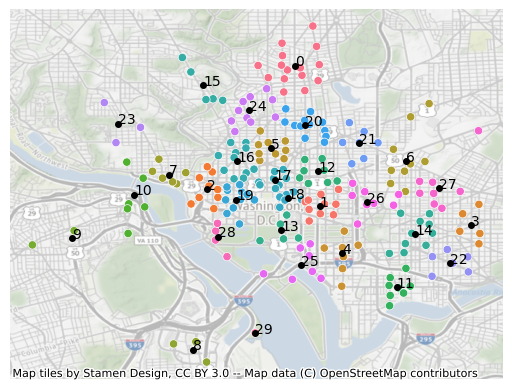

In [13]:
fig, ax = plt.subplots()
sns.scatterplot(ride_locations, x="start_lng", y="start_lat", hue="cluster_label", legend=False)
plt.plot(km.cluster_centers_[:,1], km.cluster_centers_[:,0], linestyle='None', markersize=8, marker='.', color='k')
for clus in range(km.cluster_centers_.shape[0]):
    plt.annotate(clus, [km.cluster_centers_[clus,1], km.cluster_centers_[clus,0]])
cx.add_basemap(ax, crs='EPSG:4326', alpha=0.5)
ax.axis('off');

Finally, save the clustering model object ("artefact"), and the ride locations, for potential deployment

In [2]:
with open("model_artefacts/km_clusters.pkl", "wb") as file:
    pickle.dump(km, file)
with open("data/ride_locations.pkl", "wb") as file:
    pickle.dump(ride_locations, file)

In [44]:
#with open("data/ride_locations.pkl", "rb") as file:
#    ridelocs = pickle.load(file)
#with open("model_artefacts/km_clusters.pkl", "rb") as file:
#    cluster_model = pickle.load(file)

In [7]:
import pandas as pd
cluster_df = pd.DataFrame(cluster_model.cluster_centers_, columns=["start_lat", "start_lng"])
cluster_df.rename(columns={'start_lng':'lon', 'start_lat':'lat'}, inplace=True)

Create dataframe of cluster locations, for streamlit visualization

In [13]:
cluster_df = pd.DataFrame(cluster_model.cluster_centers_, columns=["start_lat", "start_lng"])
cluster_df.rename(columns={'start_lng':'lon', 'start_lat':'lat'}, inplace=True)
cluster_df['cluster_label'] = range(0, len(cluster_df))
cluster_df['color'] = 'r'
cluster_df['size'] = 2